<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[10:03:53] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


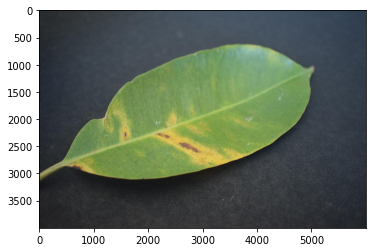

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

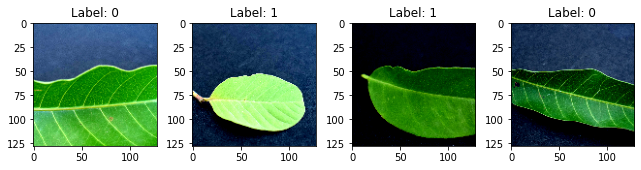

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
device = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, device=device)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), device=device))
model.hybridize()

[10:04:00] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[10:04:02] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.to_device(device))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.to_device(device))
            loss = loss_fn(outputs, label.to_device(device))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2562558143296232 samples/sec                   batch loss = 0.7940775752067566 | accuracy = 0.55


Epoch[1] Batch[10] Speed: 1.2601814091045864 samples/sec                   batch loss = 0.765285074710846 | accuracy = 0.4


Epoch[1] Batch[15] Speed: 1.266643287507413 samples/sec                   batch loss = 1.0019065141677856 | accuracy = 0.43333333333333335


Epoch[1] Batch[20] Speed: 1.2579456423320514 samples/sec                   batch loss = 0.737119734287262 | accuracy = 0.4875


Epoch[1] Batch[25] Speed: 1.259546590086339 samples/sec                   batch loss = 0.46332669258117676 | accuracy = 0.52


Epoch[1] Batch[30] Speed: 1.2446829567653883 samples/sec                   batch loss = 1.0146876573562622 | accuracy = 0.525


Epoch[1] Batch[35] Speed: 1.2568368512375905 samples/sec                   batch loss = 0.6296122074127197 | accuracy = 0.5357142857142857


Epoch[1] Batch[40] Speed: 1.2734903068117989 samples/sec                   batch loss = 0.37936022877693176 | accuracy = 0.5375


Epoch[1] Batch[45] Speed: 1.2736119235930743 samples/sec                   batch loss = 0.8194353580474854 | accuracy = 0.55


Epoch[1] Batch[50] Speed: 1.266978459528991 samples/sec                   batch loss = 0.5874214768409729 | accuracy = 0.565


Epoch[1] Batch[55] Speed: 1.2681625455505015 samples/sec                   batch loss = 0.44840264320373535 | accuracy = 0.5681818181818182


Epoch[1] Batch[60] Speed: 1.2750713945667778 samples/sec                   batch loss = 0.9060356020927429 | accuracy = 0.5708333333333333


Epoch[1] Batch[65] Speed: 1.272630951030016 samples/sec                   batch loss = 0.7098195552825928 | accuracy = 0.5692307692307692


Epoch[1] Batch[70] Speed: 1.2725841332487735 samples/sec                   batch loss = 0.5834013223648071 | accuracy = 0.5642857142857143


Epoch[1] Batch[75] Speed: 1.2724492979813846 samples/sec                   batch loss = 0.7435587644577026 | accuracy = 0.57


Epoch[1] Batch[80] Speed: 1.2678576934400827 samples/sec                   batch loss = 0.35075727105140686 | accuracy = 0.578125


Epoch[1] Batch[85] Speed: 1.2662773261838431 samples/sec                   batch loss = 0.4672605097293854 | accuracy = 0.5852941176470589


Epoch[1] Batch[90] Speed: 1.2683346346378432 samples/sec                   batch loss = 0.6327728033065796 | accuracy = 0.5888888888888889


Epoch[1] Batch[95] Speed: 1.2717244572348836 samples/sec                   batch loss = 0.45993873476982117 | accuracy = 0.6


Epoch[1] Batch[100] Speed: 1.266090316348708 samples/sec                   batch loss = 0.37579843401908875 | accuracy = 0.6075


Epoch[1] Batch[105] Speed: 1.273057392697903 samples/sec                   batch loss = 0.5573238134384155 | accuracy = 0.6071428571428571


Epoch[1] Batch[110] Speed: 1.2577118664715066 samples/sec                   batch loss = 0.3001278340816498 | accuracy = 0.6068181818181818


Epoch[1] Batch[115] Speed: 1.2745635206034562 samples/sec                   batch loss = 0.6468449234962463 | accuracy = 0.6065217391304348


Epoch[1] Batch[120] Speed: 1.2634497072233797 samples/sec                   batch loss = 0.43092405796051025 | accuracy = 0.6083333333333333


Epoch[1] Batch[125] Speed: 1.2725669515044988 samples/sec                   batch loss = 0.38490286469459534 | accuracy = 0.614


Epoch[1] Batch[130] Speed: 1.2720645424364578 samples/sec                   batch loss = 0.2952580749988556 | accuracy = 0.6076923076923076


Epoch[1] Batch[135] Speed: 1.2695523835525881 samples/sec                   batch loss = 0.59221351146698 | accuracy = 0.6055555555555555


Epoch[1] Batch[140] Speed: 1.2719599037183404 samples/sec                   batch loss = 0.4651809334754944 | accuracy = 0.6107142857142858


Epoch[1] Batch[145] Speed: 1.270730989250998 samples/sec                   batch loss = 0.2843318283557892 | accuracy = 0.6086206896551725


Epoch[1] Batch[150] Speed: 1.2711874603445688 samples/sec                   batch loss = 0.6333552002906799 | accuracy = 0.615


Epoch[1] Batch[155] Speed: 1.2654768305391675 samples/sec                   batch loss = 0.4484555423259735 | accuracy = 0.6209677419354839


Epoch[1] Batch[160] Speed: 1.2721192314548566 samples/sec                   batch loss = 0.39191389083862305 | accuracy = 0.6234375


Epoch[1] Batch[165] Speed: 1.2693299277163856 samples/sec                   batch loss = 1.0003184080123901 | accuracy = 0.6227272727272727


Epoch[1] Batch[170] Speed: 1.2650439095106747 samples/sec                   batch loss = 0.44342881441116333 | accuracy = 0.625


Epoch[1] Batch[175] Speed: 1.2642772684035053 samples/sec                   batch loss = 0.7532411217689514 | accuracy = 0.6257142857142857


Epoch[1] Batch[180] Speed: 1.263256873280334 samples/sec                   batch loss = 0.9020047187805176 | accuracy = 0.625


Epoch[1] Batch[185] Speed: 1.2730653139279307 samples/sec                   batch loss = 0.44310885667800903 | accuracy = 0.6256756756756757


Epoch[1] Batch[190] Speed: 1.270052136797169 samples/sec                   batch loss = 0.7375246286392212 | accuracy = 0.6289473684210526


Epoch[1] Batch[195] Speed: 1.2677713724632904 samples/sec                   batch loss = 0.2838995158672333 | accuracy = 0.6294871794871795


Epoch[1] Batch[200] Speed: 1.2666441481672965 samples/sec                   batch loss = 0.36010870337486267 | accuracy = 0.63125


Epoch[1] Batch[205] Speed: 1.2613944510937194 samples/sec                   batch loss = 0.25748926401138306 | accuracy = 0.6341463414634146


Epoch[1] Batch[210] Speed: 1.2654094444775472 samples/sec                   batch loss = 1.3320847749710083 | accuracy = 0.6345238095238095


Epoch[1] Batch[215] Speed: 1.2732027919489572 samples/sec                   batch loss = 0.6614631414413452 | accuracy = 0.6348837209302326


Epoch[1] Batch[220] Speed: 1.2645422750553952 samples/sec                   batch loss = 0.8068228363990784 | accuracy = 0.6352272727272728


Epoch[1] Batch[225] Speed: 1.2571982232946233 samples/sec                   batch loss = 0.7046045064926147 | accuracy = 0.6377777777777778


Epoch[1] Batch[230] Speed: 1.2620602799229759 samples/sec                   batch loss = 0.5409166216850281 | accuracy = 0.6380434782608696


Epoch[1] Batch[235] Speed: 1.272435208042033 samples/sec                   batch loss = 0.20357555150985718 | accuracy = 0.6382978723404256


Epoch[1] Batch[240] Speed: 1.2747926579514026 samples/sec                   batch loss = 0.25877633690834045 | accuracy = 0.640625


Epoch[1] Batch[245] Speed: 1.2724190918501532 samples/sec                   batch loss = 0.3711247146129608 | accuracy = 0.639795918367347


Epoch[1] Batch[250] Speed: 1.271088262408274 samples/sec                   batch loss = 0.7305718660354614 | accuracy = 0.64


Epoch[1] Batch[255] Speed: 1.2686200507290255 samples/sec                   batch loss = 0.9998545050621033 | accuracy = 0.6372549019607843


Epoch[1] Batch[260] Speed: 1.2752897603919726 samples/sec                   batch loss = 0.4505053460597992 | accuracy = 0.6394230769230769


Epoch[1] Batch[265] Speed: 1.2746909596118037 samples/sec                   batch loss = 0.9449408054351807 | accuracy = 0.6396226415094339


Epoch[1] Batch[270] Speed: 1.2653665922027963 samples/sec                   batch loss = 0.48357051610946655 | accuracy = 0.6407407407407407


Epoch[1] Batch[275] Speed: 1.2688863054843211 samples/sec                   batch loss = 0.54398113489151 | accuracy = 0.6427272727272727


Epoch[1] Batch[280] Speed: 1.2630775059008608 samples/sec                   batch loss = 0.5435540676116943 | accuracy = 0.64375


Epoch[1] Batch[285] Speed: 1.2546239967885868 samples/sec                   batch loss = 0.601057767868042 | accuracy = 0.6421052631578947


Epoch[1] Batch[290] Speed: 1.2594070346326847 samples/sec                   batch loss = 0.521655797958374 | accuracy = 0.6431034482758621


Epoch[1] Batch[295] Speed: 1.266069678893184 samples/sec                   batch loss = 0.3922097384929657 | accuracy = 0.6449152542372881


Epoch[1] Batch[300] Speed: 1.2501532027116284 samples/sec                   batch loss = 0.32539796829223633 | accuracy = 0.6466666666666666


Epoch[1] Batch[305] Speed: 1.2493880296659001 samples/sec                   batch loss = 0.5261759757995605 | accuracy = 0.648360655737705


Epoch[1] Batch[310] Speed: 1.2520979479202023 samples/sec                   batch loss = 0.5931520462036133 | accuracy = 0.6491935483870968


Epoch[1] Batch[315] Speed: 1.2624351116932553 samples/sec                   batch loss = 0.27612632513046265 | accuracy = 0.6515873015873016


Epoch[1] Batch[320] Speed: 1.261841675468307 samples/sec                   batch loss = 0.4512408971786499 | accuracy = 0.653125


Epoch[1] Batch[325] Speed: 1.2669093827488838 samples/sec                   batch loss = 0.3789719045162201 | accuracy = 0.6530769230769231


Epoch[1] Batch[330] Speed: 1.269369207210941 samples/sec                   batch loss = 0.7136653661727905 | accuracy = 0.6553030303030303


Epoch[1] Batch[335] Speed: 1.2700750195349966 samples/sec                   batch loss = 0.350629061460495 | accuracy = 0.6574626865671642


Epoch[1] Batch[340] Speed: 1.267179035356612 samples/sec                   batch loss = 0.6527395248413086 | accuracy = 0.6580882352941176


Epoch[1] Batch[345] Speed: 1.26431937997979 samples/sec                   batch loss = 0.6259340643882751 | accuracy = 0.6579710144927536


Epoch[1] Batch[350] Speed: 1.2591193227785915 samples/sec                   batch loss = 0.3873380422592163 | accuracy = 0.6592857142857143


Epoch[1] Batch[355] Speed: 1.2674871998812989 samples/sec                   batch loss = 0.3681381940841675 | accuracy = 0.6605633802816901


Epoch[1] Batch[360] Speed: 1.2651792788065706 samples/sec                   batch loss = 0.5140876173973083 | accuracy = 0.6611111111111111


Epoch[1] Batch[365] Speed: 1.2651624872425875 samples/sec                   batch loss = 0.497189998626709 | accuracy = 0.6623287671232877


Epoch[1] Batch[370] Speed: 1.266180708686792 samples/sec                   batch loss = 0.546230673789978 | accuracy = 0.6628378378378378


Epoch[1] Batch[375] Speed: 1.2592814044503544 samples/sec                   batch loss = 0.368418425321579 | accuracy = 0.6653333333333333


Epoch[1] Batch[380] Speed: 1.2628717621685617 samples/sec                   batch loss = 1.0317413806915283 | accuracy = 0.6625


Epoch[1] Batch[385] Speed: 1.2632617243251592 samples/sec                   batch loss = 0.3977145254611969 | accuracy = 0.6623376623376623


Epoch[1] Batch[390] Speed: 1.2587716731476404 samples/sec                   batch loss = 0.5637043714523315 | accuracy = 0.6641025641025641


Epoch[1] Batch[395] Speed: 1.262225778641537 samples/sec                   batch loss = 0.9089570641517639 | accuracy = 0.6651898734177215


Epoch[1] Batch[400] Speed: 1.258426292062453 samples/sec                   batch loss = 0.5562100410461426 | accuracy = 0.665625


Epoch[1] Batch[405] Speed: 1.2613483615576162 samples/sec                   batch loss = 0.7125956416130066 | accuracy = 0.6666666666666666


Epoch[1] Batch[410] Speed: 1.266754800517568 samples/sec                   batch loss = 0.48672613501548767 | accuracy = 0.6682926829268293


Epoch[1] Batch[415] Speed: 1.2670907971361414 samples/sec                   batch loss = 0.507106602191925 | accuracy = 0.6680722891566265


Epoch[1] Batch[420] Speed: 1.2646039448170334 samples/sec                   batch loss = 0.48339614272117615 | accuracy = 0.6684523809523809


Epoch[1] Batch[425] Speed: 1.2661428684630565 samples/sec                   batch loss = 0.7525061368942261 | accuracy = 0.6688235294117647


Epoch[1] Batch[430] Speed: 1.2617816033602953 samples/sec                   batch loss = 0.21888881921768188 | accuracy = 0.6703488372093023


Epoch[1] Batch[435] Speed: 1.2628662487024869 samples/sec                   batch loss = 1.368560552597046 | accuracy = 0.6701149425287356


Epoch[1] Batch[440] Speed: 1.2634945231452166 samples/sec                   batch loss = 0.8687565326690674 | accuracy = 0.6704545454545454


Epoch[1] Batch[445] Speed: 1.2744921620158975 samples/sec                   batch loss = 0.33111605048179626 | accuracy = 0.6713483146067416


Epoch[1] Batch[450] Speed: 1.2576427593932569 samples/sec                   batch loss = 0.4889911413192749 | accuracy = 0.6733333333333333


Epoch[1] Batch[455] Speed: 1.2499658027706462 samples/sec                   batch loss = 1.0259357690811157 | accuracy = 0.6747252747252748


Epoch[1] Batch[460] Speed: 1.2683157456987475 samples/sec                   batch loss = 0.5117579698562622 | accuracy = 0.6744565217391304


Epoch[1] Batch[465] Speed: 1.2719382066000742 samples/sec                   batch loss = 0.5336645245552063 | accuracy = 0.6741935483870968


Epoch[1] Batch[470] Speed: 1.2667126221904779 samples/sec                   batch loss = 0.9280654191970825 | accuracy = 0.6734042553191489


Epoch[1] Batch[475] Speed: 1.2736307772403128 samples/sec                   batch loss = 0.7038540840148926 | accuracy = 0.6731578947368421


Epoch[1] Batch[480] Speed: 1.269853726117793 samples/sec                   batch loss = 0.37607601284980774 | accuracy = 0.6734375


Epoch[1] Batch[485] Speed: 1.2738699285982964 samples/sec                   batch loss = 0.23737579584121704 | accuracy = 0.6731958762886598


Epoch[1] Batch[490] Speed: 1.2667343326792486 samples/sec                   batch loss = 0.40525931119918823 | accuracy = 0.6724489795918367


Epoch[1] Batch[495] Speed: 1.2669484169012384 samples/sec                   batch loss = 0.837623655796051 | accuracy = 0.6722222222222223


Epoch[1] Batch[500] Speed: 1.2718392771236684 samples/sec                   batch loss = 1.0311577320098877 | accuracy = 0.6715


Epoch[1] Batch[505] Speed: 1.2611650799258811 samples/sec                   batch loss = 0.7297083735466003 | accuracy = 0.6717821782178218


Epoch[1] Batch[510] Speed: 1.2608600763194933 samples/sec                   batch loss = 0.37533876299858093 | accuracy = 0.6715686274509803


Epoch[1] Batch[515] Speed: 1.2622973847674712 samples/sec                   batch loss = 0.3875374495983124 | accuracy = 0.6713592233009709


Epoch[1] Batch[520] Speed: 1.2630788371783828 samples/sec                   batch loss = 0.44807133078575134 | accuracy = 0.6721153846153847


Epoch[1] Batch[525] Speed: 1.2564475516850349 samples/sec                   batch loss = 0.6339741349220276 | accuracy = 0.670952380952381


Epoch[1] Batch[530] Speed: 1.249528816696475 samples/sec                   batch loss = 0.47498711943626404 | accuracy = 0.6698113207547169


Epoch[1] Batch[535] Speed: 1.2518818466187276 samples/sec                   batch loss = 0.7390119433403015 | accuracy = 0.6710280373831776


Epoch[1] Batch[540] Speed: 1.2569592631168383 samples/sec                   batch loss = 0.4755612313747406 | accuracy = 0.6722222222222223


Epoch[1] Batch[545] Speed: 1.263893344052847 samples/sec                   batch loss = 0.6680418252944946 | accuracy = 0.673394495412844


Epoch[1] Batch[550] Speed: 1.2634608395441207 samples/sec                   batch loss = 0.6564850211143494 | accuracy = 0.6736363636363636


Epoch[1] Batch[555] Speed: 1.2568090764763384 samples/sec                   batch loss = 0.5857461094856262 | accuracy = 0.6743243243243243


Epoch[1] Batch[560] Speed: 1.263784999772511 samples/sec                   batch loss = 1.6755425930023193 | accuracy = 0.6736607142857143


Epoch[1] Batch[565] Speed: 1.261021469108303 samples/sec                   batch loss = 0.6259254813194275 | accuracy = 0.6738938053097345


Epoch[1] Batch[570] Speed: 1.256120843004436 samples/sec                   batch loss = 0.7496733665466309 | accuracy = 0.6741228070175439


Epoch[1] Batch[575] Speed: 1.2648787199957057 samples/sec                   batch loss = 0.7397922277450562 | accuracy = 0.6752173913043479


Epoch[1] Batch[580] Speed: 1.2653207845174455 samples/sec                   batch loss = 0.08423373103141785 | accuracy = 0.6771551724137931


Epoch[1] Batch[585] Speed: 1.2600178654819632 samples/sec                   batch loss = 0.297307550907135 | accuracy = 0.6782051282051282


Epoch[1] Batch[590] Speed: 1.2565119163009222 samples/sec                   batch loss = 0.35677921772003174 | accuracy = 0.6792372881355933


Epoch[1] Batch[595] Speed: 1.2533743065982879 samples/sec                   batch loss = 0.5979641079902649 | accuracy = 0.6789915966386555


Epoch[1] Batch[600] Speed: 1.2570176525653034 samples/sec                   batch loss = 0.686805784702301 | accuracy = 0.6804166666666667


Epoch[1] Batch[605] Speed: 1.2615371034286944 samples/sec                   batch loss = 0.5042139887809753 | accuracy = 0.6797520661157025


Epoch[1] Batch[610] Speed: 1.2636132864398273 samples/sec                   batch loss = 0.5110746622085571 | accuracy = 0.6807377049180328


Epoch[1] Batch[615] Speed: 1.2715376661562745 samples/sec                   batch loss = 0.3051212430000305 | accuracy = 0.6817073170731708


Epoch[1] Batch[620] Speed: 1.2705199545626658 samples/sec                   batch loss = 1.2054452896118164 | accuracy = 0.6826612903225806


Epoch[1] Batch[625] Speed: 1.2584808530645568 samples/sec                   batch loss = 0.7460395693778992 | accuracy = 0.682


Epoch[1] Batch[630] Speed: 1.263934477853444 samples/sec                   batch loss = 0.44484782218933105 | accuracy = 0.6821428571428572


Epoch[1] Batch[635] Speed: 1.264987156515584 samples/sec                   batch loss = 0.6218552589416504 | accuracy = 0.6822834645669291


Epoch[1] Batch[640] Speed: 1.265153328395551 samples/sec                   batch loss = 0.5369178056716919 | accuracy = 0.683203125


Epoch[1] Batch[645] Speed: 1.2547055338928792 samples/sec                   batch loss = 1.3440428972244263 | accuracy = 0.6841085271317829


Epoch[1] Batch[650] Speed: 1.2612411168481963 samples/sec                   batch loss = 0.8589098453521729 | accuracy = 0.6842307692307692


Epoch[1] Batch[655] Speed: 1.2749833134137962 samples/sec                   batch loss = 0.19616401195526123 | accuracy = 0.6854961832061068


Epoch[1] Batch[660] Speed: 1.2571080727373432 samples/sec                   batch loss = 0.7526722550392151 | accuracy = 0.6856060606060606


Epoch[1] Batch[665] Speed: 1.2625319184609183 samples/sec                   batch loss = 0.26008254289627075 | accuracy = 0.6857142857142857


Epoch[1] Batch[670] Speed: 1.2671517586725176 samples/sec                   batch loss = 0.5970380902290344 | accuracy = 0.6850746268656717


Epoch[1] Batch[675] Speed: 1.2711776361688987 samples/sec                   batch loss = 0.5042455196380615 | accuracy = 0.6855555555555556


Epoch[1] Batch[680] Speed: 1.2691700497274954 samples/sec                   batch loss = 0.6322071552276611 | accuracy = 0.6856617647058824


Epoch[1] Batch[685] Speed: 1.2642581190444542 samples/sec                   batch loss = 1.0573965311050415 | accuracy = 0.6854014598540146


Epoch[1] Batch[690] Speed: 1.2670081208458102 samples/sec                   batch loss = 0.43126344680786133 | accuracy = 0.6847826086956522


Epoch[1] Batch[695] Speed: 1.270275326758353 samples/sec                   batch loss = 0.534115731716156 | accuracy = 0.6834532374100719


Epoch[1] Batch[700] Speed: 1.271441593254876 samples/sec                   batch loss = 0.5523179173469543 | accuracy = 0.6832142857142857


Epoch[1] Batch[705] Speed: 1.2682868860204486 samples/sec                   batch loss = 0.5566949844360352 | accuracy = 0.6829787234042554


Epoch[1] Batch[710] Speed: 1.2693427965250854 samples/sec                   batch loss = 0.3338797092437744 | accuracy = 0.6841549295774648


Epoch[1] Batch[715] Speed: 1.2630214046134882 samples/sec                   batch loss = 0.22896859049797058 | accuracy = 0.6849650349650349


Epoch[1] Batch[720] Speed: 1.2629629314575348 samples/sec                   batch loss = 0.7690245509147644 | accuracy = 0.6847222222222222


Epoch[1] Batch[725] Speed: 1.259186607596662 samples/sec                   batch loss = 0.33502987027168274 | accuracy = 0.6851724137931035


Epoch[1] Batch[730] Speed: 1.2643995140523872 samples/sec                   batch loss = 0.46217626333236694 | accuracy = 0.684931506849315


Epoch[1] Batch[735] Speed: 1.268440020313529 samples/sec                   batch loss = 0.3911864459514618 | accuracy = 0.6857142857142857


Epoch[1] Batch[740] Speed: 1.2736387056074074 samples/sec                   batch loss = 0.34473052620887756 | accuracy = 0.6864864864864865


Epoch[1] Batch[745] Speed: 1.2639502846092812 samples/sec                   batch loss = 0.703624427318573 | accuracy = 0.6869127516778524


Epoch[1] Batch[750] Speed: 1.2646681945207563 samples/sec                   batch loss = 0.5322045683860779 | accuracy = 0.687


Epoch[1] Batch[755] Speed: 1.2680899849315632 samples/sec                   batch loss = 0.7088230848312378 | accuracy = 0.6870860927152318


Epoch[1] Batch[760] Speed: 1.2638755392796417 samples/sec                   batch loss = 0.8406715393066406 | accuracy = 0.6875


Epoch[1] Batch[765] Speed: 1.2639166719213042 samples/sec                   batch loss = 0.4412955939769745 | accuracy = 0.6879084967320261


Epoch[1] Batch[770] Speed: 1.257113818625321 samples/sec                   batch loss = 1.1928834915161133 | accuracy = 0.6876623376623376


Epoch[1] Batch[775] Speed: 1.2678861503226428 samples/sec                   batch loss = 0.6158624291419983 | accuracy = 0.6887096774193548


Epoch[1] Batch[780] Speed: 1.2543342458297493 samples/sec                   batch loss = 0.43109849095344543 | accuracy = 0.6897435897435897


Epoch[1] Batch[785] Speed: 1.2582619768655874 samples/sec                   batch loss = 0.3128539025783539 | accuracy = 0.6901273885350319


[Epoch 1] training: accuracy=0.6900380710659898
[Epoch 1] time cost: 650.333696603775
[Epoch 1] validation: validation accuracy=0.6822222222222222


Epoch[2] Batch[5] Speed: 1.2580640250886697 samples/sec                   batch loss = 0.23638053238391876 | accuracy = 0.75


Epoch[2] Batch[10] Speed: 1.2602373530383633 samples/sec                   batch loss = 0.5235534906387329 | accuracy = 0.775


Epoch[2] Batch[15] Speed: 1.2616961077435649 samples/sec                   batch loss = 0.6334977746009827 | accuracy = 0.7333333333333333


Epoch[2] Batch[20] Speed: 1.2643969412192242 samples/sec                   batch loss = 0.3087456524372101 | accuracy = 0.7375


Epoch[2] Batch[25] Speed: 1.2564344725473313 samples/sec                   batch loss = 0.6974153518676758 | accuracy = 0.71


Epoch[2] Batch[30] Speed: 1.2489420568918277 samples/sec                   batch loss = 0.4262881278991699 | accuracy = 0.7083333333333334


Epoch[2] Batch[35] Speed: 1.260633930580743 samples/sec                   batch loss = 0.7827803492546082 | accuracy = 0.7


Epoch[2] Batch[40] Speed: 1.2680713908123489 samples/sec                   batch loss = 0.5417208075523376 | accuracy = 0.7125


Epoch[2] Batch[45] Speed: 1.2656406486828364 samples/sec                   batch loss = 0.7398270964622498 | accuracy = 0.7


Epoch[2] Batch[50] Speed: 1.2691853156158546 samples/sec                   batch loss = 0.9013570547103882 | accuracy = 0.69


Epoch[2] Batch[55] Speed: 1.2715635900180702 samples/sec                   batch loss = 0.8500493168830872 | accuracy = 0.6772727272727272


Epoch[2] Batch[60] Speed: 1.266827973666144 samples/sec                   batch loss = 0.41593271493911743 | accuracy = 0.6875


Epoch[2] Batch[65] Speed: 1.266606662731834 samples/sec                   batch loss = 0.4816802442073822 | accuracy = 0.6884615384615385


Epoch[2] Batch[70] Speed: 1.269957922446136 samples/sec                   batch loss = 0.5442746877670288 | accuracy = 0.6928571428571428


Epoch[2] Batch[75] Speed: 1.2619150414244586 samples/sec                   batch loss = 0.5833128690719604 | accuracy = 0.6966666666666667


Epoch[2] Batch[80] Speed: 1.2574410441100772 samples/sec                   batch loss = 0.7506841421127319 | accuracy = 0.709375


Epoch[2] Batch[85] Speed: 1.2574505628624624 samples/sec                   batch loss = 0.49175575375556946 | accuracy = 0.7058823529411765


Epoch[2] Batch[90] Speed: 1.256686034927587 samples/sec                   batch loss = 0.33251944184303284 | accuracy = 0.7083333333333334


Epoch[2] Batch[95] Speed: 1.2617371935361261 samples/sec                   batch loss = 0.36680272221565247 | accuracy = 0.7105263157894737


Epoch[2] Batch[100] Speed: 1.2534084845779025 samples/sec                   batch loss = 0.3449753522872925 | accuracy = 0.705


Epoch[2] Batch[105] Speed: 1.250148172357126 samples/sec                   batch loss = 0.38252854347229004 | accuracy = 0.7095238095238096


Epoch[2] Batch[110] Speed: 1.251515961900755 samples/sec                   batch loss = 0.40375053882598877 | accuracy = 0.7090909090909091


Epoch[2] Batch[115] Speed: 1.2558950777811015 samples/sec                   batch loss = 0.5034149885177612 | accuracy = 0.7130434782608696


Epoch[2] Batch[120] Speed: 1.2679965406216587 samples/sec                   batch loss = 0.2717455327510834 | accuracy = 0.7166666666666667


Epoch[2] Batch[125] Speed: 1.2647612442400655 samples/sec                   batch loss = 0.504277765750885 | accuracy = 0.718


Epoch[2] Batch[130] Speed: 1.2616713436968983 samples/sec                   batch loss = 0.33281463384628296 | accuracy = 0.7192307692307692


Epoch[2] Batch[135] Speed: 1.26812161535616 samples/sec                   batch loss = 0.5445815324783325 | accuracy = 0.7185185185185186


Epoch[2] Batch[140] Speed: 1.263658780217792 samples/sec                   batch loss = 0.30401432514190674 | accuracy = 0.7160714285714286


Epoch[2] Batch[145] Speed: 1.2608879356590932 samples/sec                   batch loss = 0.08934467285871506 | accuracy = 0.7172413793103448


Epoch[2] Batch[150] Speed: 1.2613834499930718 samples/sec                   batch loss = 0.19819137454032898 | accuracy = 0.7183333333333334


Epoch[2] Batch[155] Speed: 1.2711771545955641 samples/sec                   batch loss = 0.5982145071029663 | accuracy = 0.7193548387096774


Epoch[2] Batch[160] Speed: 1.2593774445303436 samples/sec                   batch loss = 0.603613555431366 | accuracy = 0.721875


Epoch[2] Batch[165] Speed: 1.2570110599365607 samples/sec                   batch loss = 0.2653771638870239 | accuracy = 0.7272727272727273


Epoch[2] Batch[170] Speed: 1.2617737270309486 samples/sec                   batch loss = 0.3801446259021759 | accuracy = 0.7294117647058823


Epoch[2] Batch[175] Speed: 1.2658714598289613 samples/sec                   batch loss = 0.36525943875312805 | accuracy = 0.7257142857142858


Epoch[2] Batch[180] Speed: 1.2625654575358052 samples/sec                   batch loss = 0.4363694489002228 | accuracy = 0.7236111111111111


Epoch[2] Batch[185] Speed: 1.264989540992726 samples/sec                   batch loss = 0.4143099784851074 | accuracy = 0.7216216216216216


Epoch[2] Batch[190] Speed: 1.2629133998979565 samples/sec                   batch loss = 0.6651278734207153 | accuracy = 0.7210526315789474


Epoch[2] Batch[195] Speed: 1.2612544858832204 samples/sec                   batch loss = 0.16166703402996063 | accuracy = 0.7256410256410256


Epoch[2] Batch[200] Speed: 1.2611978827603978 samples/sec                   batch loss = 0.3948095142841339 | accuracy = 0.7225


Epoch[2] Batch[205] Speed: 1.2625012312934636 samples/sec                   batch loss = 0.43471759557724 | accuracy = 0.7207317073170731


Epoch[2] Batch[210] Speed: 1.2683737566664932 samples/sec                   batch loss = 0.4278078079223633 | accuracy = 0.719047619047619


Epoch[2] Batch[215] Speed: 1.2651261388495953 samples/sec                   batch loss = 0.24163885414600372 | accuracy = 0.7197674418604652


Epoch[2] Batch[220] Speed: 1.2607975394286302 samples/sec                   batch loss = 0.22188925743103027 | accuracy = 0.7215909090909091


Epoch[2] Batch[225] Speed: 1.2567522126591828 samples/sec                   batch loss = 0.4834769666194916 | accuracy = 0.7244444444444444


Epoch[2] Batch[230] Speed: 1.2722322896238913 samples/sec                   batch loss = 0.2926640808582306 | accuracy = 0.7282608695652174


Epoch[2] Batch[235] Speed: 1.2660002235110202 samples/sec                   batch loss = 0.2536868453025818 | accuracy = 0.7308510638297873


Epoch[2] Batch[240] Speed: 1.2665312204570127 samples/sec                   batch loss = 0.5824410319328308 | accuracy = 0.73125


Epoch[2] Batch[245] Speed: 1.2663289380100076 samples/sec                   batch loss = 0.3862690031528473 | accuracy = 0.7295918367346939


Epoch[2] Batch[250] Speed: 1.2744483051392719 samples/sec                   batch loss = 0.375870943069458 | accuracy = 0.728


Epoch[2] Batch[255] Speed: 1.2671143388866772 samples/sec                   batch loss = 0.4872627854347229 | accuracy = 0.7274509803921568


Epoch[2] Batch[260] Speed: 1.267118836800337 samples/sec                   batch loss = 0.38646817207336426 | accuracy = 0.7269230769230769


Epoch[2] Batch[265] Speed: 1.2695252927921827 samples/sec                   batch loss = 0.6107200384140015 | accuracy = 0.7235849056603774


Epoch[2] Batch[270] Speed: 1.2699492708085591 samples/sec                   batch loss = 0.3588670492172241 | accuracy = 0.7240740740740741


Epoch[2] Batch[275] Speed: 1.2665103774079862 samples/sec                   batch loss = 0.49037718772888184 | accuracy = 0.7254545454545455


Epoch[2] Batch[280] Speed: 1.2622741166339209 samples/sec                   batch loss = 0.6172693967819214 | accuracy = 0.7267857142857143


Epoch[2] Batch[285] Speed: 1.2666772366452097 samples/sec                   batch loss = 0.7623846530914307 | accuracy = 0.7263157894736842


Epoch[2] Batch[290] Speed: 1.2582843423503343 samples/sec                   batch loss = 0.39446115493774414 | accuracy = 0.7241379310344828


Epoch[2] Batch[295] Speed: 1.2581408207184037 samples/sec                   batch loss = 0.8373059034347534 | accuracy = 0.7254237288135593


Epoch[2] Batch[300] Speed: 1.2545205190389377 samples/sec                   batch loss = 0.43408530950546265 | accuracy = 0.7266666666666667


Epoch[2] Batch[305] Speed: 1.2569867619877473 samples/sec                   batch loss = 0.6232765316963196 | accuracy = 0.7270491803278688


Epoch[2] Batch[310] Speed: 1.2721517384434498 samples/sec                   batch loss = 0.7507208585739136 | accuracy = 0.7266129032258064


Epoch[2] Batch[315] Speed: 1.2707835423038523 samples/sec                   batch loss = 0.2637594938278198 | accuracy = 0.7253968253968254


Epoch[2] Batch[320] Speed: 1.2645322673924086 samples/sec                   batch loss = 1.4734455347061157 | accuracy = 0.725


Epoch[2] Batch[325] Speed: 1.2692379329383165 samples/sec                   batch loss = 0.7135606408119202 | accuracy = 0.7223076923076923


Epoch[2] Batch[330] Speed: 1.2675669698830359 samples/sec                   batch loss = 0.622443437576294 | accuracy = 0.725


Epoch[2] Batch[335] Speed: 1.2644011339897503 samples/sec                   batch loss = 0.7683011293411255 | accuracy = 0.7261194029850746


Epoch[2] Batch[340] Speed: 1.260351149427403 samples/sec                   batch loss = 0.23669806122779846 | accuracy = 0.7272058823529411


Epoch[2] Batch[345] Speed: 1.264526739417912 samples/sec                   batch loss = 0.41739335656166077 | accuracy = 0.7304347826086957


Epoch[2] Batch[350] Speed: 1.2608054983247592 samples/sec                   batch loss = 0.3780008852481842 | accuracy = 0.7321428571428571


Epoch[2] Batch[355] Speed: 1.2546264361799184 samples/sec                   batch loss = 0.21626782417297363 | accuracy = 0.7330985915492958


Epoch[2] Batch[360] Speed: 1.2498902812056754 samples/sec                   batch loss = 0.15777727961540222 | accuracy = 0.7333333333333333


Epoch[2] Batch[365] Speed: 1.2518399056382883 samples/sec                   batch loss = 2.7861344814300537 | accuracy = 0.7321917808219178


Epoch[2] Batch[370] Speed: 1.250669681494457 samples/sec                   batch loss = 0.43060293793678284 | accuracy = 0.7324324324324324


Epoch[2] Batch[375] Speed: 1.255566683076059 samples/sec                   batch loss = 0.5362173318862915 | accuracy = 0.73


Epoch[2] Batch[380] Speed: 1.2603700859289835 samples/sec                   batch loss = 0.5793881416320801 | accuracy = 0.7289473684210527


Epoch[2] Batch[385] Speed: 1.2631780252468217 samples/sec                   batch loss = 0.5727592706680298 | accuracy = 0.7285714285714285


Epoch[2] Batch[390] Speed: 1.2588810487153757 samples/sec                   batch loss = 0.9682201743125916 | accuracy = 0.7282051282051282


Epoch[2] Batch[395] Speed: 1.2574934461577576 samples/sec                   batch loss = 0.5879659056663513 | accuracy = 0.7284810126582278


Epoch[2] Batch[400] Speed: 1.2582957613221348 samples/sec                   batch loss = 0.9463911652565002 | accuracy = 0.7275


Epoch[2] Batch[405] Speed: 1.2575429305177688 samples/sec                   batch loss = 0.5479745268821716 | accuracy = 0.725925925925926


Epoch[2] Batch[410] Speed: 1.2622026081071982 samples/sec                   batch loss = 0.21472255885601044 | accuracy = 0.7280487804878049


Epoch[2] Batch[415] Speed: 1.2507017541505514 samples/sec                   batch loss = 0.15187156200408936 | accuracy = 0.7289156626506024


Epoch[2] Batch[420] Speed: 1.244669844390452 samples/sec                   batch loss = 0.5325857400894165 | accuracy = 0.7279761904761904


Epoch[2] Batch[425] Speed: 1.2592558844516812 samples/sec                   batch loss = 0.5590397119522095 | accuracy = 0.7258823529411764


Epoch[2] Batch[430] Speed: 1.2636964721049582 samples/sec                   batch loss = 0.6985687613487244 | accuracy = 0.7255813953488373


Epoch[2] Batch[435] Speed: 1.2653890200914972 samples/sec                   batch loss = 0.7079689502716064 | accuracy = 0.725287356321839


Epoch[2] Batch[440] Speed: 1.2606432135596186 samples/sec                   batch loss = 0.6432866454124451 | accuracy = 0.7255681818181818


Epoch[2] Batch[445] Speed: 1.2654052450172246 samples/sec                   batch loss = 0.1197565495967865 | accuracy = 0.7258426966292135


Epoch[2] Batch[450] Speed: 1.2618067513350635 samples/sec                   batch loss = 0.26113903522491455 | accuracy = 0.7277777777777777


Epoch[2] Batch[455] Speed: 1.2633215569415075 samples/sec                   batch loss = 0.49013084173202515 | accuracy = 0.7263736263736263


Epoch[2] Batch[460] Speed: 1.2587820620651022 samples/sec                   batch loss = 0.6252335906028748 | accuracy = 0.7266304347826087


Epoch[2] Batch[465] Speed: 1.2640918964969425 samples/sec                   batch loss = 0.2698569595813751 | accuracy = 0.7263440860215054


Epoch[2] Batch[470] Speed: 1.2613813635990792 samples/sec                   batch loss = 0.438796728849411 | accuracy = 0.7244680851063829


Epoch[2] Batch[475] Speed: 1.257986767202337 samples/sec                   batch loss = 0.5982235074043274 | accuracy = 0.7252631578947368


Epoch[2] Batch[480] Speed: 1.2642394465962352 samples/sec                   batch loss = 0.5521470904350281 | accuracy = 0.7270833333333333


Epoch[2] Batch[485] Speed: 1.254866199566558 samples/sec                   batch loss = 0.23772922158241272 | accuracy = 0.7268041237113402


Epoch[2] Batch[490] Speed: 1.2539506185850025 samples/sec                   batch loss = 0.39400845766067505 | accuracy = 0.7280612244897959


Epoch[2] Batch[495] Speed: 1.2517766725463177 samples/sec                   batch loss = 0.38751673698425293 | accuracy = 0.7282828282828283


Epoch[2] Batch[500] Speed: 1.25675889671518 samples/sec                   batch loss = 0.4883643090724945 | accuracy = 0.7295


Epoch[2] Batch[505] Speed: 1.2665429808286952 samples/sec                   batch loss = 0.5333353877067566 | accuracy = 0.7292079207920792


Epoch[2] Batch[510] Speed: 1.2633733086400007 samples/sec                   batch loss = 0.38928136229515076 | accuracy = 0.7299019607843137


Epoch[2] Batch[515] Speed: 1.2595497105820708 samples/sec                   batch loss = 0.795433521270752 | accuracy = 0.7310679611650486


Epoch[2] Batch[520] Speed: 1.2641108503271938 samples/sec                   batch loss = 0.2865285575389862 | accuracy = 0.7322115384615384


Epoch[2] Batch[525] Speed: 1.2603766191540522 samples/sec                   batch loss = 0.6218599081039429 | accuracy = 0.7333333333333333


Epoch[2] Batch[530] Speed: 1.2556327429657743 samples/sec                   batch loss = 0.5693527460098267 | accuracy = 0.7339622641509433


Epoch[2] Batch[535] Speed: 1.2557966541313172 samples/sec                   batch loss = 0.12071289122104645 | accuracy = 0.7350467289719627


Epoch[2] Batch[540] Speed: 1.2569028565272513 samples/sec                   batch loss = 1.0494388341903687 | accuracy = 0.7361111111111112


Epoch[2] Batch[545] Speed: 1.2565781698100065 samples/sec                   batch loss = 0.6957424283027649 | accuracy = 0.7357798165137615


Epoch[2] Batch[550] Speed: 1.2571869184405149 samples/sec                   batch loss = 0.6990978717803955 | accuracy = 0.7368181818181818


Epoch[2] Batch[555] Speed: 1.2525816198314035 samples/sec                   batch loss = 0.3867805302143097 | accuracy = 0.736936936936937


Epoch[2] Batch[560] Speed: 1.2586345555067422 samples/sec                   batch loss = 2.301866054534912 | accuracy = 0.7370535714285714


Epoch[2] Batch[565] Speed: 1.265478453238205 samples/sec                   batch loss = 0.25858330726623535 | accuracy = 0.7376106194690265


Epoch[2] Batch[570] Speed: 1.2660497108845141 samples/sec                   batch loss = 0.41738712787628174 | accuracy = 0.737280701754386


Epoch[2] Batch[575] Speed: 1.264947098643643 samples/sec                   batch loss = 0.680956244468689 | accuracy = 0.7360869565217392


Epoch[2] Batch[580] Speed: 1.259772440435464 samples/sec                   batch loss = 0.12101031839847565 | accuracy = 0.7370689655172413


Epoch[2] Batch[585] Speed: 1.254519111934236 samples/sec                   batch loss = 0.5939948558807373 | accuracy = 0.7380341880341881


Epoch[2] Batch[590] Speed: 1.2580904402180022 samples/sec                   batch loss = 0.5472801327705383 | accuracy = 0.7377118644067797


Epoch[2] Batch[595] Speed: 1.2622706027454502 samples/sec                   batch loss = 0.6129536628723145 | accuracy = 0.7361344537815127


Epoch[2] Batch[600] Speed: 1.2598605137524428 samples/sec                   batch loss = 0.3339174687862396 | accuracy = 0.7358333333333333


Epoch[2] Batch[605] Speed: 1.2509942133035112 samples/sec                   batch loss = 0.449652761220932 | accuracy = 0.7355371900826446


Epoch[2] Batch[610] Speed: 1.2535659146239728 samples/sec                   batch loss = 0.36077725887298584 | accuracy = 0.7368852459016394


Epoch[2] Batch[615] Speed: 1.259015480130332 samples/sec                   batch loss = 0.46424299478530884 | accuracy = 0.7378048780487805


Epoch[2] Batch[620] Speed: 1.2643051836824817 samples/sec                   batch loss = 0.13852913677692413 | accuracy = 0.7383064516129032


Epoch[2] Batch[625] Speed: 1.2672969607094657 samples/sec                   batch loss = 1.6873252391815186 | accuracy = 0.7388


Epoch[2] Batch[630] Speed: 1.2688963821830093 samples/sec                   batch loss = 0.6639879941940308 | accuracy = 0.7380952380952381


Epoch[2] Batch[635] Speed: 1.2674281210100646 samples/sec                   batch loss = 0.2681335210800171 | accuracy = 0.739763779527559


Epoch[2] Batch[640] Speed: 1.2659349786981282 samples/sec                   batch loss = 0.24615271389484406 | accuracy = 0.741015625


Epoch[2] Batch[645] Speed: 1.265970131729525 samples/sec                   batch loss = 0.2631032168865204 | accuracy = 0.7422480620155039


Epoch[2] Batch[650] Speed: 1.2729444775884762 samples/sec                   batch loss = 0.18028712272644043 | accuracy = 0.7430769230769231


Epoch[2] Batch[655] Speed: 1.2715038414427764 samples/sec                   batch loss = 0.8501847982406616 | accuracy = 0.7419847328244275


Epoch[2] Batch[660] Speed: 1.2631657566549315 samples/sec                   batch loss = 0.5608093738555908 | accuracy = 0.7424242424242424


Epoch[2] Batch[665] Speed: 1.2629976343847713 samples/sec                   batch loss = 0.4086710810661316 | accuracy = 0.7424812030075187


Epoch[2] Batch[670] Speed: 1.261417686807637 samples/sec                   batch loss = 0.37772971391677856 | accuracy = 0.7421641791044776


Epoch[2] Batch[675] Speed: 1.2579882764230372 samples/sec                   batch loss = 0.7025225162506104 | accuracy = 0.7411111111111112


Epoch[2] Batch[680] Speed: 1.254051471434089 samples/sec                   batch loss = 0.2792816460132599 | accuracy = 0.7419117647058824


Epoch[2] Batch[685] Speed: 1.257369893644679 samples/sec                   batch loss = 0.3814499080181122 | accuracy = 0.7401459854014598


Epoch[2] Batch[690] Speed: 1.2572550332643353 samples/sec                   batch loss = 2.569136381149292 | accuracy = 0.7402173913043478


Epoch[2] Batch[695] Speed: 1.2605117490098494 samples/sec                   batch loss = 0.40488362312316895 | accuracy = 0.7406474820143885


Epoch[2] Batch[700] Speed: 1.2647629604495463 samples/sec                   batch loss = 0.2514369785785675 | accuracy = 0.74


Epoch[2] Batch[705] Speed: 1.2611884968039955 samples/sec                   batch loss = 0.9033666253089905 | accuracy = 0.7393617021276596


Epoch[2] Batch[710] Speed: 1.2721991032313684 samples/sec                   batch loss = 0.5736344456672668 | accuracy = 0.7390845070422535


Epoch[2] Batch[715] Speed: 1.2627010571720678 samples/sec                   batch loss = 0.5936322212219238 | accuracy = 0.7388111888111888


Epoch[2] Batch[720] Speed: 1.2628631117518976 samples/sec                   batch loss = 0.33940398693084717 | accuracy = 0.7395833333333334


Epoch[2] Batch[725] Speed: 1.2661058904295566 samples/sec                   batch loss = 0.7021434903144836 | accuracy = 0.7386206896551725


Epoch[2] Batch[730] Speed: 1.2598287264735064 samples/sec                   batch loss = 0.9125387668609619 | accuracy = 0.7393835616438356


Epoch[2] Batch[735] Speed: 1.2585785649508423 samples/sec                   batch loss = 0.9779447317123413 | accuracy = 0.7391156462585035


Epoch[2] Batch[740] Speed: 1.252651855296345 samples/sec                   batch loss = 0.3117254376411438 | accuracy = 0.7398648648648649


Epoch[2] Batch[745] Speed: 1.2553158503714497 samples/sec                   batch loss = 0.47922149300575256 | accuracy = 0.7399328859060402


Epoch[2] Batch[750] Speed: 1.2620453748253586 samples/sec                   batch loss = 0.4990403354167938 | accuracy = 0.7396666666666667


Epoch[2] Batch[755] Speed: 1.25813874503757 samples/sec                   batch loss = 0.20606255531311035 | accuracy = 0.7400662251655629


Epoch[2] Batch[760] Speed: 1.2618555317742144 samples/sec                   batch loss = 0.551157534122467 | accuracy = 0.7401315789473685


Epoch[2] Batch[765] Speed: 1.265948925047613 samples/sec                   batch loss = 0.43216758966445923 | accuracy = 0.7395424836601308


Epoch[2] Batch[770] Speed: 1.2621721268556558 samples/sec                   batch loss = 0.3416113257408142 | accuracy = 0.7402597402597403


Epoch[2] Batch[775] Speed: 1.2698962100099869 samples/sec                   batch loss = 0.5507922768592834 | accuracy = 0.7409677419354839


Epoch[2] Batch[780] Speed: 1.257476952236503 samples/sec                   batch loss = 0.9497252702713013 | accuracy = 0.7413461538461539


Epoch[2] Batch[785] Speed: 1.2569899639892783 samples/sec                   batch loss = 0.3431621193885803 | accuracy = 0.7417197452229299


[Epoch 2] training: accuracy=0.7414340101522843
[Epoch 2] time cost: 642.5074174404144
[Epoch 2] validation: validation accuracy=0.7955555555555556


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.8044444444444444

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)